In [ ]:
import os
import glob
import cv2
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

C:\Users\Subha\anaconda3\envs\py37\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras import datasets, models
from tensorflow.keras import layers, activations, initializers
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.input_spec import InputSpec

In [ ]:
class HyperConv2D(layers.Layer):
    def __init__(self,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='VALID',
                 use_bias=True,
                 activation=None,
                 initializer='glorot_normal',
                 data_format=None,
                 algebra = np.array([[-1,+1,-1],[-1,-1,1],[1,-1,-1]]) # Quaternion algebra
                ):
        super(HyperConv2D, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
        self.activation = activations.get(activation)
        self.initializer = initializers.get(initializer)
        self.data_format = data_format
        self.algebra = algebra

    def _get_channel_axis(self):
        if self.data_format == 'channels_first':
            raise ValueError('HyperConv2d is designed only for channels_last. '
                             'The input must be changed to channels last!')
        else:
            return -1

    def _get_input_channel(self, input_shape):
        channel_axis = self._get_channel_axis()
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        return int(input_shape[channel_axis])

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        if input_channel % 4 != 0:
            raise ValueError('The number of input channels must be divisible by 4.')

        input_dim = input_channel // 4
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel_r = self.add_weight(
            name='real_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        self.kernel_i = self.add_weight(
            name='imag_i_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        self.kernel_j = self.add_weight(
            name='imag_j_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        self.kernel_k = self.add_weight(
            name='imag_k_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(4*self.filters,),
                initializer="zeros",
                trainable=True,
                dtype=self.dtype)
        else:
            self.bias = None

    def call(self, inputs):
        # Filter multiplied from the right!
        F_r = tf.concat([self.kernel_r,self.algebra[0,0]*self.kernel_i,self.algebra[1,1]*self.kernel_j,self.algebra[2,2]*self.kernel_k],axis=2)
        F_i = tf.concat([self.kernel_i,self.kernel_r,self.algebra[1,2]*self.kernel_k,self.algebra[2,1]*self.kernel_j],axis=2)
        F_j = tf.concat([self.kernel_j,self.algebra[0,2]*self.kernel_k,self.kernel_r,self.algebra[2,0]*self.kernel_i],axis=2)
        F_k = tf.concat([self.kernel_k,self.algebra[0,1]*self.kernel_j,self.algebra[1,0]*self.kernel_i,self.kernel_r],axis=2)

        y_r = tf.nn.conv2d(inputs, F_r, strides=self.strides, padding=self.padding)
        y_i = tf.nn.conv2d(inputs, F_i, strides=self.strides, padding=self.padding)
        y_j = tf.nn.conv2d(inputs, F_j, strides=self.strides, padding=self.padding)
        y_k = tf.nn.conv2d(inputs, F_k, strides=self.strides, padding=self.padding)

        outputs = tf.concat([y_r, y_i, y_j, y_k],axis=3)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs,self.bias)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [ ]:
image_size = (256,256)
dataset_path = 'C:/Users/Subha/Desktop/test1/*.jpg'

N=800
imgs_list = [f for f in glob.glob(dataset_path)]
Xr_rgb = np.zeros((N,image_size[0],image_size[1],3))
Xq_rgb = np.zeros((N,image_size[0],image_size[1],4))
Xr_hsv = np.zeros((N,image_size[0],image_size[1],3))
Xq_hsv = np.zeros((N,image_size[0],image_size[1],4))
y = np.zeros((N,))

z = np.zeros((image_size[0],image_size[1],1))
for i,img_path in enumerate(imgs_list):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, image_size)

    # RGB images
    Xr_rgb[i,:,:,:] = img_resized/255
    Xq_rgb[i,:,:,:] = np.concatenate([z,img_resized/255],axis=2)

    # Convert to HSV
    img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
    H = np.reshape((2*np.pi/180)*img_hsv[:,:,0],(image_size[0],image_size[1],1))
    S = np.reshape(img_hsv[:,:,1]/255,(image_size[0],image_size[1],1))
    V = np.reshape(img_hsv[:,:,2]/255,(image_size[0],image_size[1],1))

    # Real-valued images;
    Xr_hsv[i,:,:,:] = np.concatenate([H,S,V],axis=2)

    # Quaternion-valued images obtained using HSV;
    Xq_hsv[i,:,:,:] = np.concatenate([H,S,V,V],axis=2)
    ind = img_path.find("Luminal")
    if(ind!=-1):
        y[i]=0
    else:
        ind = img_path.find("HER")
        if(ind!=-1):
            y[i]=1
        else:
            ind = img_path.find("ERPR")
            if(ind!=-1):
                y[i]=2
            else:
                ind = img_path.find("Triple")
                if(ind!=-1):
                    y[i]=3

In [ ]:
y

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
y = y.astype(int)

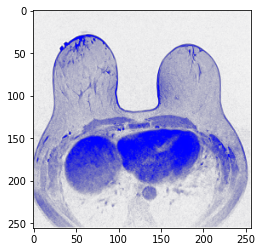

In [ ]:
plt.imshow(Xq_hsv[6,:,:,:])

In [ ]:
 indtr, indte, ytr, yte = train_test_split(range(800), y, test_size=0.15)

In [ ]:
Xtr = Xq_hsv[indtr]
Xte = Xq_hsv[indte]

In [ ]:
Xtr.shape

(680, 256, 256, 4)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:

quaternions = np.array([[-1,+1,-1],[-1,-1,1],[1,-1,-1]]) # Quaternion algebra

datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=64)
batch = it.next()

H_algebra = tf.Variable((3,3))
model_hyper = kr.Sequential(
    [
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(16, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(32, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dense(128,kernel_regularizer=tf.keras.regularizers.l1(0.001),activation="relu"),
        layers.Dropout(0.8),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128,kernel_regularizer=tf.keras.regularizers.l2(0.001),activation="relu"),
        layers.Dropout(0.6),
        layers.Dense(4, activation='softmax')
    ]
)

In [ ]:
model_hyper.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
hist = model_hyper.fit(datagen.flow(Xtr, ytr, batch_size=64),epochs=120, verbose=1,shuffle=True)
xx=model_hyper.predict(Xtr)
yy=model_hyper.predict(Xte)
a = np.argmax(yy, axis=1)
b = np.argmax(xx, axis=1)
Acc_te = len([a[i] for i in range(0, len(a)) if a[i] == yte[i]]) / len(a)
Acc_tr = len([b[i] for i in range(0, len(b)) if b[i] == ytr[i]]) / len(b)
print("Quaternion-valued Accuracy (Train/Test) = %2.2f/%2.2f" % (Acc_tr,Acc_te))

Epoch 1/120
11/11 [==============================] - 69s 6s/step - loss: 5.1053 - accuracy: 0.2574
Epoch 2/120
11/11 [==============================] - 69s 6s/step - loss: 3.2547 - accuracy: 0.3147
Epoch 3/120
11/11 [==============================] - 66s 6s/step - loss: 3.0857 - accuracy: 0.3338
Epoch 4/120
11/11 [==============================] - 68s 6s/step - loss: 3.0114 - accuracy: 0.3603
Epoch 5/120
11/11 [==============================] - 68s 6s/step - loss: 2.9202 - accuracy: 0.3721
Epoch 6/120
11/11 [==============================] - 65s 6s/step - loss: 2.9043 - accuracy: 0.3824
Epoch 7/120
11/11 [==============================] - 66s 6s/step - loss: 2.7900 - accuracy: 0.3926
Epoch 8/120
11/11 [==============================] - 80s 7s/step - loss: 2.7351 - accuracy: 0.3868
Epoch 9/120
11/11 [==============================] - 78s 7s/step - loss: 2.6193 - accuracy: 0.4279
Epoch 10/120
11/11 [==============================] - 69s 6s/step - loss: 2.5896 - accuracy: 0.4235
Epoch 11/

In [ ]:
a

array([1, 2, 0, 2, 0, 1, 3, 2, 3, 0, 0, 0, 3, 1, 2, 2, 0, 0, 3, 2, 3, 2,
       2, 3, 3, 2, 0, 2, 3, 2, 1, 2, 2, 1, 0, 2, 0, 2, 0, 1, 3, 3, 2, 0,
       0, 1, 3, 2, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 1, 1, 0, 0, 2, 1, 3, 2,
       3, 1, 1, 3, 3, 2, 3, 0, 3, 2, 0, 2, 3, 1, 1, 3, 0, 1, 1, 1, 2, 2,
       3, 2, 3, 0, 2, 2, 3, 0, 0, 1, 3, 1, 3, 0, 0, 2, 0, 3, 3, 1, 1, 2,
       1, 2, 3, 3, 2, 1, 3, 3, 3, 2], dtype=int64)

In [ ]:
yte

array([1, 2, 0, 2, 0, 1, 3, 2, 3, 0, 0, 0, 3, 1, 2, 2, 3, 0, 3, 2, 3, 2,
       2, 3, 3, 2, 0, 2, 3, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 1, 3, 3, 2, 0,
       0, 1, 3, 2, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 1, 1, 0, 0, 2, 1, 3, 2,
       3, 1, 1, 3, 3, 2, 3, 0, 3, 2, 0, 2, 3, 1, 1, 3, 0, 1, 1, 1, 2, 2,
       3, 2, 3, 0, 2, 2, 3, 0, 0, 1, 3, 1, 3, 0, 0, 2, 0, 3, 3, 1, 1, 2,
       1, 2, 3, 3, 2, 1, 3, 3, 3, 2])

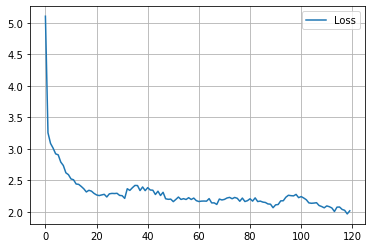

In [ ]:
plt.plot(hist.history['loss'], label='Loss')
#plt.plot(hist.history['accuracy'], label='Accuracy')
plt.grid()
plt.legend()

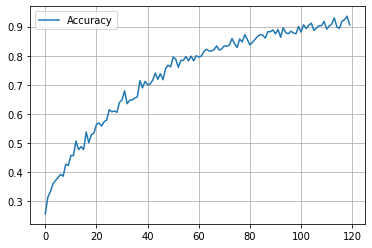

In [ ]:
#plt.plot(hist.history['loss'], label='Validation Accuracy')
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.grid()
plt.legend()

In [ ]:
from sklearn.metrics import classification_report

target_names = ['Luminal_like', 'HER2', 'ER/PR and HER','Triple negative']
print(classification_report(yte, a, target_names=target_names))

                 precision    recall  f1-score   support

   Luminal_like       0.92      1.00      0.96        24
           HER2       1.00      1.00      1.00        29
  ER/PR and HER       1.00      0.97      0.99        35
Triple negative       1.00      0.97      0.98        32

       accuracy                           0.98       120
      macro avg       0.98      0.99      0.98       120
   weighted avg       0.98      0.98      0.98       120

